In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import torch.optim as optim
import numpy as np
from collections import OrderedDict
import time
import os
import inspect
from PIL import Image
import PIL.Image as pil
import pickle
import matplotlib.pyplot as plt
import datetime
import torch.utils.model_zoo as model_zoo
import skimage.transform
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data loader
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

class Dataset(data.Dataset):
    def __init__(self, path):
        self.data_path = path
        self.height = 192
        self.width = 640
        self.num_scales = 4
        self.frame_idxs = [0, -1, 1]
        self.interp = Image.LANCZOS

        self.filenames = []
        for i in range(2):
          dir = self.data_path + f"/train{i}"
          list_dir = [f"train{i}/" + x for x in os.listdir(dir)]
          self.filenames.extend(list_dir)

        self.resize = {}
        for i in range(self.num_scales):
            s = 2 ** i
            self.resize[i] = transforms.Resize((self.height // s, self.width // s), interpolation=self.interp)

        self.K = np.array([[0.58, 0, 0.5, 0],
                   [0, 1.92, 0.5, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]], dtype=np.float32)

    def __getitem__(self, index):
        inputs = {}

        for i in self.frame_idxs:
            inputs[("color", i, -1)] = self.get_color(self.filenames[min(max(index + i, 0), len(self.filenames)-1)])

        for k in list(inputs):
            frame = inputs[k]
            if "color" in k:
                n, im, i = k
                for i in range(self.num_scales):
                    inputs[(n, im, i)] = self.resize[i](inputs[(n, im, i - 1)])

        for k in list(inputs):
            f = inputs[k]
            if "color" in k:
                n, im, i = k
                inputs[(n, im, i)] = transforms.ToTensor()(f)

        # adjusting intrinsics to match each scale in the pyramid
        for scale in range(self.num_scales):
            K = self.K.copy()

            K[0, :] *= self.width // (2 ** scale)
            K[1, :] *= self.height // (2 ** scale)

            inv_K = np.linalg.pinv(K)

            inputs[("K", scale)] = torch.from_numpy(K)
            inputs[("inv_K", scale)] = torch.from_numpy(inv_K)

        for i in self.frame_idxs:
            del inputs[("color", i, -1)]
        return inputs

    def __len__(self):
        return len(self.filenames)

    def get_color(self, img_name):
        color = pil_loader(os.path.join(self.data_path, img_name))
        return color

In [ ]:
"""# Test dataset
train_dataset = Dataset()
train_loader = data.DataLoader(train_dataset, batch_size = 12)"""

'# Test dataset\ntrain_dataset = Dataset()\ntrain_loader = data.DataLoader(train_dataset, batch_size = 12)'

In [ ]:
"""# Test dataloader
for batch_idx, inputs in enumerate(train_loader):
        print(batch_idx, inputs[('color',0,0)].size())"""

"# Test dataloader\nfor batch_idx, inputs in enumerate(train_loader):\n        print(batch_idx, inputs[('color',0,0)].size())"

In [ ]:
class ResNetMultiImageInput(models.ResNet):
    """Constructs a resnet model with varying number of input images.
    Adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    """
    def __init__(self, block, layers, num_classes=1000, num_input_images=1):
        super(ResNetMultiImageInput, self).__init__(block, layers)
        self.inplanes = 64
        self.conv1 = nn.Conv2d(
            num_input_images * 3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def resnet_multiimage_input(num_input_images=1):
    """Constructs a ResNet model.
    Args:
        num_layers (int): Number of resnet layers. Must be 18 or 50
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        num_input_images (int): Number of frames stacked as input
    """
    blocks = [2, 2, 2, 2]
    block_type = models.resnet.BasicBlock
    model = ResNetMultiImageInput(block_type, blocks, num_input_images=num_input_images)

    loaded = torch.hub.load_state_dict_from_url(models.ResNet18_Weights.IMAGENET1K_V1.url)
    loaded['conv1.weight'] = torch.cat([loaded['conv1.weight']] * num_input_images, 1) / num_input_images
    model.load_state_dict(loaded)
    return model

In [ ]:
# DepthEncoder class
class DepthEncoder(nn.Module):
    def __init__(self, learning_rate=0.00001, momentum=0.08, num_input_images = 1):
        super(DepthEncoder, self).__init__()

        # Load the pre-trained ResNet-18 model
        self.model = resnet_multiimage_input(num_input_images)

        # Get the number of features in the last fully connected layer of the model
        self.num_features = self.model.fc.in_features

        # Define the number of channels in the encoder features
        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        # Define the CrossEntropyLoss criterion for training
        self.criterion = nn.CrossEntropyLoss()

        # Define the optimizer for training
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=momentum)

    def forward(self, input_image):
        self.features = []

        # Preprocess the input image by normalizing it
        x = (input_image - 0.45) / 0.225

        # Apply the initial convolution and batch normalization layers
        x = self.model.conv1(x)
        x = self.model.bn1(x)

        # Store the result of the initial layers in the features list
        self.features.append(self.model.relu(x))

        # Apply the first residual layer and store the result
        self.features.append(self.model.layer1(self.model.maxpool(self.features[-1])))

        # Apply the second, third, and fourth residual layers and store the results
        self.features.append(self.model.layer2(self.features[-1]))
        self.features.append(self.model.layer3(self.features[-1]))
        self.features.append(self.model.layer4(self.features[-1]))

        # Return the list of feature maps at different encoder stages
        return self.features

In [ ]:
class ConvBlock(nn.Module):
    # Constructor for ConvBlock
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # Define a 3x3 convolution layer
        self.conv = Conv3x3(in_channels, out_channels)

        # Apply the ELU activation function in-place
        self.nonlin = nn.ELU(inplace=True)

    # Forward pass through the ConvBlock
    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out

# Sample Conv3x3 class (you may need to define this)
class Conv3x3(nn.Module):
    # Constructor for Conv3x3
    def __init__(self, in_channels, out_channels, use_refl=True):
        super(Conv3x3, self).__init__()

        # Use either ReflectionPad2d or ZeroPad2d based on the 'use_refl' flag
        if use_refl:
            self.pad = nn.ReflectionPad2d(1)
        else:
            self.pad = nn.ZeroPad2d(1)

        # Define a 3x3 convolution layer
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    # Forward pass through the Conv3x3 layer
    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out

In [ ]:
# DepthDecoder
class DepthDecoder(nn.Module):
    def __init__(self, num_ch_enc, scales=range(4), num_output_channels=1):
        super(DepthDecoder, self).__init__()

        # Store the number of output channels and scales
        self.num_output_channels = num_output_channels
        self.scales = scales

        # Store the number of channels in the encoder features
        self.num_ch_enc = num_ch_enc

        # Define the number of channels in the decoder
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        # Create an ordered dictionary to store convolutional layers
        self.convs = OrderedDict()

        # Define the decoder layers
        for i in range(4, -1, -1):
            # Calculate the number of input channels for upconv_0
            if i == 4:
                num_ch_in = self.num_ch_enc[-1]
            else:
                num_ch_in = self.num_ch_dec[i + 1]

            num_ch_out = self.num_ch_dec[i]

            # Create upconv_0 layer
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)

            # Calculate the number of input channels for upconv_1
            num_ch_in = self.num_ch_dec[i]

            if i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]

            # Create upconv_1 layer
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        # Create convolutional layers for disparity prediction at different scales
        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        # Create a ModuleList from the ordered dictionary values
        self.decoder = nn.ModuleList(list(self.convs.values()))

        # Sigmoid activation for final disparity prediction
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        # Initial input is the last feature map from the encoder
        x = input_features[-1]

        # Decoder operations
        for i in range(4, -1, -1):
            # Apply the upconv_0 layer
            x = self.convs[("upconv", i, 0)](x)

            # Upsample the feature map, height x2, width x2
            x = [F.interpolate(x, scale_factor=2, mode="nearest")]

            # If not at the first scale, concatenate with the encoder feature map
            if i > 0:
                x += [input_features[i - 1]]

            # Concatenate feature maps along the channel dimension
            x = torch.cat(x, 1)

            # Apply the upconv_1 layer
            x = self.convs[("upconv", i, 1)](x)

            # If the current scale is in the specified scales, predict disparity
            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))

        return self.outputs

In [ ]:
class PoseDecoder(nn.Module):
    def __init__(self, num_ch_enc, num_input_features, num_frames_to_predict_for=None, stride=1):
        super(PoseDecoder, self).__init__()

        self.num_ch_enc = num_ch_enc
        self.num_input_features = num_input_features

        if num_frames_to_predict_for is None:
            num_frames_to_predict_for = num_input_features - 1
        self.num_frames_to_predict_for = num_frames_to_predict_for

        self.convs = OrderedDict()
        self.convs[("squeeze")] = nn.Conv2d(self.num_ch_enc[-1], 256, 1)
        self.convs[("pose", 0)] = nn.Conv2d(num_input_features * 256, 256, 3, stride, 1)
        self.convs[("pose", 1)] = nn.Conv2d(256, 256, 3, stride, 1)
        self.convs[("pose", 2)] = nn.Conv2d(256, 6 * num_frames_to_predict_for, 1)

        self.relu = nn.ReLU()

        self.net = nn.ModuleList(list(self.convs.values()))

    def forward(self, input_features):
        last_features = []
        for f in input_features:
            last_features.append(f[-1])

        cat_features = []
        for f in last_features:
            cat_features.append(self.relu(self.convs["squeeze"](f)))
        cat_features = torch.cat(cat_features, 1)

        out = cat_features
        for i in range(3):
            out = self.convs[("pose", i)](out)
            if i != 2:
                out = self.relu(out)

        out = out.mean(3).mean(2)

        out = 0.01 * out.view(-1, self.num_frames_to_predict_for, 1, 6)

        axisangle = out[..., :3]
        translation = out[..., 3:]

        return axisangle, translation

In [ ]:
class SSIM(nn.Module):
    """Layer to compute the SSIM loss between a pair of images
    """
    def __init__(self):
        super(SSIM, self).__init__()
        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)

In [ ]:
class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """
    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords), requires_grad=False)

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width), requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1), requires_grad=False)

    def forward(self, depth, inv_K):
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)
        cam_points = depth.view(self.batch_size, 1, -1) * cam_points
        cam_points = torch.cat([cam_points, self.ones], 1)

        return cam_points

In [ ]:
class Project3D(nn.Module):
    """Layer which projects 3D points into a camera with intrinsics K and at position T
    """
    def __init__(self, batch_size, height, width, eps=1e-7):
        super(Project3D, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.eps = eps

    def forward(self, points, K, T):
        P = torch.matmul(K, T)[:, :3, :]

        cam_points = torch.matmul(P, points)

        pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)
        pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
        pix_coords = pix_coords.permute(0, 2, 3, 1)
        pix_coords[..., 0] /= self.width - 1
        pix_coords[..., 1] /= self.height - 1
        pix_coords = (pix_coords - 0.5) * 2
        return pix_coords

In [ ]:
def transformation_from_parameters(axisangle, translation, invert=False):
    """Convert the network's (axisangle, translation) output into a 4x4 matrix
    """
    R = rot_from_axisangle(axisangle)
    t = translation.clone()

    if invert:
        R = R.transpose(1, 2)
        t *= -1

    T = get_translation_matrix(t)

    if invert:
        M = torch.matmul(R, T)
    else:
        M = torch.matmul(T, R)

    return M

def rot_from_axisangle(vec):
    """Convert an axisangle rotation into a 4x4 transformation matrix
    (adapted from https://github.com/Wallacoloo/printipi)
    Input 'vec' has to be Bx1x3
    """
    angle = torch.norm(vec, 2, 2, True)
    axis = vec / (angle + 1e-7)

    ca = torch.cos(angle)
    sa = torch.sin(angle)
    C = 1 - ca

    x = axis[..., 0].unsqueeze(1)
    y = axis[..., 1].unsqueeze(1)
    z = axis[..., 2].unsqueeze(1)

    xs = x * sa
    ys = y * sa
    zs = z * sa
    xC = x * C
    yC = y * C
    zC = z * C
    xyC = x * yC
    yzC = y * zC
    zxC = z * xC

    rot = torch.zeros((vec.shape[0], 4, 4)).to(device=vec.device)

    rot[:, 0, 0] = torch.squeeze(x * xC + ca)
    rot[:, 0, 1] = torch.squeeze(xyC - zs)
    rot[:, 0, 2] = torch.squeeze(zxC + ys)
    rot[:, 1, 0] = torch.squeeze(xyC + zs)
    rot[:, 1, 1] = torch.squeeze(y * yC + ca)
    rot[:, 1, 2] = torch.squeeze(yzC - xs)
    rot[:, 2, 0] = torch.squeeze(zxC - ys)
    rot[:, 2, 1] = torch.squeeze(yzC + xs)
    rot[:, 2, 2] = torch.squeeze(z * zC + ca)
    rot[:, 3, 3] = 1

    return rot

def get_translation_matrix(translation_vector):
    """Convert a translation vector into a 4x4 transformation matrix
    """
    T = torch.zeros(translation_vector.shape[0], 4, 4).to(device=translation_vector.device)

    t = translation_vector.contiguous().view(-1, 3, 1)

    T[:, 0, 0] = 1
    T[:, 1, 1] = 1
    T[:, 2, 2] = 1
    T[:, 3, 3] = 1
    T[:, :3, 3, None] = t

    return T

def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def get_smooth_loss(disp, img):
    """Computes the smoothness loss for a disparity image
    The color image is used for edge-aware smoothness
    """
    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()

In [ ]:
# Use separate network for pose encoder
class Trainer:
    def __init__(self, train_loader, batch_size):
        self.models = {}
        self.best_models = {}
        self.param = []
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
        self.scales = range(4)
        self.num_scales = 4
        self.num_ch_enc = [64, 64, 128, 256, 512]
        self.frame_ids = [0, -1, 1]
        self.learning_rate = 0.00001
        self.scheduler_step_size = 10
        self.start_time = time.time()
        self.start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        self.train_loader = train_loader
        self.height = 192
        self.width = 640
        self.ssim = SSIM()
        self.ssim.to(self.device)
        self.batch_size = batch_size
        self.parameters_to_train = []
        self.num_input_images = 3

        self.models["encoder"] = DepthEncoder(learning_rate = self.learning_rate)
        self.models["encoder"].to(self.device)
        self.parameters_to_train += list(self.models["encoder"].parameters())

        self.models["depth"] = DepthDecoder(self.num_ch_enc)
        self.models["depth"].to(self.device)
        self.parameters_to_train += list(self.models["depth"].parameters())

        self.models["pose_encoder"] = DepthEncoder(learning_rate = self.learning_rate, num_input_images=self.num_input_images)
        self.models["pose_encoder"].to(self.device)
        self.parameters_to_train += list(self.models["pose_encoder"].parameters())

        self.models["pose"] = PoseDecoder(self.num_ch_enc,num_input_features=1,num_frames_to_predict_for=3)
        self.models["pose"].to(self.device)
        self.parameters_to_train += list(self.models["pose"].parameters())

        self.model_optimizer = optim.Adam(self.parameters_to_train, self.learning_rate)
        self.model_lr_scheduler = optim.lr_scheduler.StepLR(self.model_optimizer, self.scheduler_step_size, 0.1)
        self.best_loss = 1000000000
        self.loss_history = []

        self.min_depth = 0.1
        self.max_depth = 100

        self.backproject_depth = {}
        self.project_3d = {}
        for scale in self.scales:
            h = self.height // (2 ** scale)
            w = self.width // (2 ** scale)

            self.backproject_depth[scale] = BackprojectDepth(self.batch_size, h, w)
            self.backproject_depth[scale].to(self.device)

            self.project_3d[scale] = Project3D(self.batch_size, h, w)
            self.project_3d[scale].to(self.device)

    def train(self, num_epochs=60):
        """Run the entire training pipeline
        """
        self.epoch = 0
        self.step = 0
        os.makedirs("drive/MyDrive/Colab Notebooks/DoAn/Models/start_time_{}_separate".format(self.start_datetime))
        for self.epoch in range(num_epochs):
            print("Running epoch ", self.epoch)
            self.run_epoch()
            print("Done epoch ", self.epoch)

    def run_epoch(self):
        self.model_lr_scheduler.step()
        #Update:
        for batch_idx, inputs in enumerate(self.train_loader):
            print("Run batch ", batch_idx)
            outputs, losses = self.process_batch(inputs)
            msg = "Done batch {}, loss = {}, time elapsed = {}"
            print(msg.format(batch_idx, losses["loss"], time.time() - self.start_time))

            if (losses["loss"].item() < self.best_loss):
              self.best_loss = losses["loss"].item()
              self.best_model = self.models.copy()

            if (batch_idx % 10 == 0):
              self.loss_history.append(losses["loss"].item())

            self.model_optimizer.zero_grad()
            losses["loss"].backward()
            self.model_optimizer.step()

    def process_batch(self, inputs):
        for key, ipt in inputs.items():
            inputs[key] = ipt.to(self.device)

        features = self.models["encoder"](inputs["color", 0, 0])
        outputs = self.models["depth"](features)

        outputs.update(self.predict_poses(inputs, features))
        self.generate_images_pred(inputs, outputs)
        losses = self.compute_losses(inputs, outputs)
        return outputs, losses

    def compute_losses(self, inputs, outputs):
        losses = {}
        total_loss = 0
        source_scale = 0

        for s in self.scales:
            loss = 0
            reprojection_losses = []

            disp = outputs[("disp", s)]
            color = inputs[("color", 0, s)]
            target = inputs[("color", 0, source_scale)]

            for frame_id in self.frame_ids[1:]:
                pred = outputs[("color", frame_id, s)]
                reprojection_losses.append(self.compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)
            reprojection_loss = reprojection_losses

            identity_reprojection_losses = []
            for frame_id in self.frame_ids[1:]:
                pred = inputs[("color", frame_id, source_scale)]
                identity_reprojection_losses.append(self.compute_reprojection_loss(pred, target))

            identity_reprojection_losses = torch.cat(identity_reprojection_losses, 1)
            identity_reprojection_loss = identity_reprojection_losses

            # add random numbers to break ties
            identity_reprojection_loss += torch.randn(identity_reprojection_loss.shape, device=self.device) * 0.00001

            combined = torch.cat((identity_reprojection_loss, reprojection_loss), dim=1)

            if combined.shape[1] == 1:
                to_optimise = combined
            else:
                to_optimise, idxs = torch.min(combined, dim=1)

            outputs["identity_selection/{}".format(s)] = (idxs > identity_reprojection_loss.shape[1] - 1).float()
            loss += to_optimise.mean()

            mean_disp = disp.mean(2, True).mean(3, True)
            norm_disp = disp / (mean_disp + 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

            loss += 1e-3 * smooth_loss / (2 ** s)
            total_loss += loss
            losses["loss/{}".format(s)] = loss

        total_loss /= self.num_scales
        losses["loss"] = total_loss
        return losses

    def compute_reprojection_loss(self, pred, target):
        """Computes reprojection loss between a batch of predicted and target images
        """
        abs_diff = torch.abs(target - pred)
        l1_loss = abs_diff.mean(1, True)

        ssim_loss = self.ssim(pred, target).mean(1, True)
        reprojection_loss = 0.85 * ssim_loss + 0.15 * l1_loss

        return reprojection_loss

    def predict_poses(self, inputs, features):
        """Predict poses between input frames for monocular sequences.
        """
        outputs = {}
        pose_inputs = torch.cat(
                    [inputs[("color", i, 0)] for i in self.frame_ids if i != "s"], 1)
        pose_inputs = [self.models["pose_encoder"](pose_inputs)]
        axisangle, translation = self.models["pose"](pose_inputs)
        for i, f_i in enumerate(self.frame_ids[1:]):
          outputs[("axisangle", 0, f_i)] = axisangle
          outputs[("translation", 0, f_i)] = translation
          outputs[("cam_T_cam", 0, f_i)] = transformation_from_parameters(axisangle[:, i], translation[:, i])

        return outputs

    def generate_images_pred(self, inputs, outputs):
        """
        Generate the warped (reprojected) color images for a minibatch.
        Generated images are saved into the `outputs` dictionary.
        """
        for scale in self.scales:
            disp = outputs[("disp", scale)]
            disp = F.interpolate(disp, [self.height, self.width], mode="bilinear", align_corners=False)
            source_scale = 0

            _, depth = disp_to_depth(disp, self.min_depth, self.max_depth)

            outputs[("depth", 0, scale)] = depth

            for i, frame_id in enumerate(self.frame_ids[1:]):
                T = outputs[("cam_T_cam", 0, frame_id)]

                cam_points = self.backproject_depth[source_scale](
                    depth, inputs[("inv_K", source_scale)])
                pix_coords = self.project_3d[source_scale](cam_points, inputs[("K", source_scale)], T)

                outputs[("sample", frame_id, scale)] = pix_coords

                outputs[("color", frame_id, scale)] = F.grid_sample(
                    inputs[("color", frame_id, source_scale)],
                    outputs[("sample", frame_id, scale)],
                    padding_mode="border")

                outputs[("color_identity", frame_id, scale)] = \
                    inputs[("color", frame_id, source_scale)]

    def pred(self, image_path):
        # Load image
        input_image = pil.open(image_path).convert('RGB')
        original_width, original_height = input_image.size
        input_image = input_image.resize((self.width, self.height), pil.LANCZOS)
        input_image = transforms.ToTensor()(input_image).unsqueeze(0)
        input_image = input_image.to(self.device)

        # Produce output
        with torch.no_grad():
            features = self.models["encoder"](input_image)
            outputs = self.models["depth"](features)

        disp = outputs[("disp", 0)]

        # Plotting
        disp_resized = torch.nn.functional.interpolate(disp,(self.height, self.width), mode="bilinear", align_corners=False)

        # Convert disp_resized to a numpy array and normalize the values
        disp_resized_np = disp_resized.squeeze().detach().cpu().numpy()
        disp_resized_np -= disp_resized_np.min()
        disp_resized_np /= disp_resized_np.max()

        vmax = np.percentile(disp_resized_np, 95)

        plt.figure(figsize=(10, 10))
        plt.subplot(211)
        plt.imshow(input_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
        plt.title("Input", fontsize=22)
        plt.axis('off')

        plt.subplot(212)
        plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
        plt.title("Disparity prediction", fontsize=22)
        plt.axis('off')

    def plot_loss(self):
        loss_value = self.loss_history
        epochs = [epoch // 8 for epoch in range(len(loss_value))]
        plt.plot(epochs, loss_value, label='Training Loss')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        plt.show()



    def read_calib_file(self, path):
        """Read KITTI calibration file
        (from https://github.com/hunse/kitti)
        """
        float_chars = set("0123456789.e+- ")
        data = {}
        with open(path, 'r') as f:
            for line in f.readlines():
                key, value = line.split(':', 1)
                value = value.strip()
                data[key] = value
                if float_chars.issuperset(value):
                    # try to cast to float array
                    try:
                        data[key] = np.array(list(map(float, value.split(' '))))
                    except ValueError:
                        # casting error: data[key] already eq. value, so pass
                        pass

        return data
    def load_velodyne_points(self, filename):
        """Load 3D point cloud from KITTI file format
        (adapted from https://github.com/hunse/kitti)
        """
        points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
        points[:, 3] = 1.0  # homogeneous
        return points

    def sub2ind(self, matrixSize, rowSub, colSub):
        """Convert row, col matrix subscripts to linear indices
        """
        m, n = matrixSize
        return rowSub * (n-1) + colSub - 1

    def generate_depth_map(self, calib_dir, velo_filename, cam=2, vel_depth=False):
        """Generate a depth map from velodyne data
        """
        # load calibration files
        cam2cam = self.read_calib_file(os.path.join(calib_dir, 'calib_cam_to_cam.txt'))
        velo2cam = self.read_calib_file(os.path.join(calib_dir, 'calib_velo_to_cam.txt'))
        velo2cam = np.hstack((velo2cam['R'].reshape(3, 3), velo2cam['T'][..., np.newaxis]))
        velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

        # get image shape
        im_shape = cam2cam["S_rect_02"][::-1].astype(np.int32)

        # compute projection matrix velodyne->image plane
        R_cam2rect = np.eye(4)
        R_cam2rect[:3, :3] = cam2cam['R_rect_00'].reshape(3, 3)
        P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3, 4)
        P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

        # load velodyne points and remove all behind image plane (approximation)
        # each row of the velodyne data is forward, left, up, reflectance
        velo = self.load_velodyne_points(velo_filename)
        velo = velo[velo[:, 0] >= 0, :]

        # project the points to the camera
        velo_pts_im = np.dot(P_velo2im, velo.T).T
        velo_pts_im[:, :2] = velo_pts_im[:, :2] / velo_pts_im[:, 2][..., np.newaxis]

        if vel_depth:
            velo_pts_im[:, 2] = velo[:, 0]

        # check if in bounds
        # use minus 1 to get the exact same value as KITTI matlab code
        velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
        velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1
        val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
        val_inds = val_inds & (velo_pts_im[:, 0] < im_shape[1]) & (velo_pts_im[:, 1] < im_shape[0])
        velo_pts_im = velo_pts_im[val_inds, :]

        # project to image
        depth = np.zeros((im_shape[:2]))
        depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

        # find the duplicate points and choose the closest depth
        inds = self.sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
        dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
        for dd in dupe_inds:
            pts = np.where(inds == dd)[0]
            x_loc = int(velo_pts_im[pts[0], 0])
            y_loc = int(velo_pts_im[pts[0], 1])
            depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
        depth[depth < 0] = 0

        return depth

    def get_depth(self, folder_path, frame_index):
        calib_path = folder_path

        velo_filename = os.path.join(
            folder_path,
            "velodyne_points/data/{:010d}.bin".format(int(frame_index)))
        full_res_shape = (640, 192)
        depth_gt = self.generate_depth_map(calib_path, velo_filename)
        depth_gt = skimage.transform.resize(depth_gt, full_res_shape[::-1], order=0, preserve_range=True, mode='constant')

        return depth_gt

    def compute_errors(self, gt, pred):
        """Computation of error metrics between predicted and ground truth depths
        """
        thresh = np.maximum((gt / pred), (pred / gt))
        a1 = (thresh < 1.25     ).mean()
        a2 = (thresh < 1.25 ** 2).mean()
        a3 = (thresh < 1.25 ** 3).mean()

        rmse = (gt - pred) ** 2
        rmse = np.sqrt(rmse.mean())

        rmse_log = (np.log(gt) - np.log(pred)) ** 2
        rmse_log = np.sqrt(rmse_log.mean())

        abs_rel = np.mean(np.abs(gt - pred) / gt)

        sq_rel = np.mean(((gt - pred) ** 2) / gt)

        return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

    # Evaluation
    def evaluate(self, path):
        img_list = os.listdir(os.path.join(path, "image_02/data"))
        img_list = list(map(lambda x: "image_02/data/" + x, img_list))
        MIN_DEPTH = 1e-3
        MAX_DEPTH = 80
        # calculate errors
        errors = []
        for i in range(len(img_list)):
            # read and convert the depth map to RGB
            gt_depth = self.get_depth(path, i)
            mask = gt_depth > 0

            # Read the image and calculate the depth map
            input_image = pil.open(os.path.join(path, img_list[i])).convert('RGB')
            original_width, original_height = input_image.size
            input_image = input_image.resize((self.width, self.height), pil.LANCZOS)
            input_image = transforms.ToTensor()(input_image).unsqueeze(0)
            input_image = input_image.to(self.device)

            # Produce output
            with torch.no_grad():
                features = self.models["encoder"](input_image)
                outputs = self.models["depth"](features)

                _, pred_depth = disp_to_depth(outputs[("disp", 0)], self.min_depth, self.max_depth)
                pred_depth = pred_depth.squeeze().detach().cpu().numpy()

            pred_depth = pred_depth[mask]
            gt_depth = gt_depth[mask]

            pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
            pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

            errors.append(self.compute_errors(gt_depth, pred_depth))


        mean_errors = np.array(errors).mean(0)
        print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
        print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")

    def save_model(self, models, mode=None): # if there is not any loss
        """Save model weights to disk
        """
        save_folder = "drive/MyDrive/Colab Notebooks/DoAn/Models/start_time{}_separate/{}".format(self.start_datetime, mode)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        for model_name, model in models.items():
            save_path = os.path.join(save_folder, "{}.pth".format(model_name))
            to_save = model.state_dict()
            if model_name == 'encoder':
                # save the sizes - these are needed at prediction time
                to_save['height'] = self.height
                to_save['width'] = self.width
            torch.save(to_save, save_path)

        save_path = os.path.join(save_folder, "{}.pth".format("adam"))
        torch.save(self.model_optimizer.state_dict(), save_path)

        save_path = os.path.join(save_folder, "{}.txt".format("loss"))
        with open(save_path, 'w') as file:
          for loss in self.loss_history:
              file.write(str(loss) + '\n')

    def load_model(self, folder_path=None):
        models_to_load = ["encoder", "depth", "pose_encoder", "pose"]
        for n in models_to_load:
            path = os.path.join(folder_path, "{}.pth".format(n))
            model_dict = self.models[n].state_dict()
            pretrained_dict = torch.load(path)
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
            model_dict.update(pretrained_dict)
            self.models[n].load_state_dict(model_dict)

        # loading adam state
        optimizer_load_path = os.path.join(folder_path, "adam.pth")
        optimizer_dict = torch.load(optimizer_load_path)
        self.model_optimizer.load_state_dict(optimizer_dict)

        # loading loss
        if os.path.isfile(os.path.join(folder_path, "loss.txt")):
            self.history_loss = []
            with open(os.path.join(folder_path, "loss.txt"), 'r') as file:
              lines = file.readlines()

            for line in lines:
                loss_value = float(line.strip())
                self.loss_history.append(loss_value)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


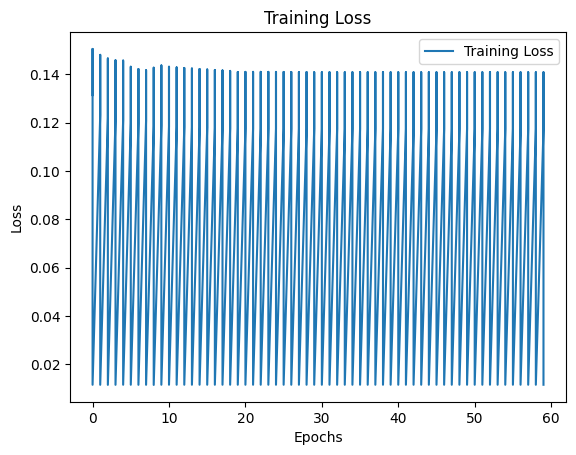

In [ ]:
folder_path = "drive/MyDrive/Colab Notebooks/DoAn/Data/"
train_dataset = Dataset(folder_path)
train_loader = data.DataLoader(train_dataset, batch_size = 16)
trainer = Trainer(train_loader, batch_size = 16)

#### only ENABLE these lines when training ##
# trainer.train(60)
# trainer.save_model(trainer.models, "final")
# trainer.save_model(trainer.best_model, "best")

#### only ENABLE these lines when testing trained parameters ##
path = "drive/MyDrive/Colab Notebooks/DoAn/Models/start_time2023-11-20 02:42:32_separate/final"
trainer.load_model(path)

trainer.plot_loss()

In [ ]:
folder_path = "drive/MyDrive/Colab Notebooks/DoAn/Data/test/"
trainer.evaluate(folder_path)

<ipython-input-15-89232f4e13ad>:336: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]



   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
& 25250.291  & 4065.044  &   4.531  &   4.524  &   0.069  &   0.124  &   0.165  \\


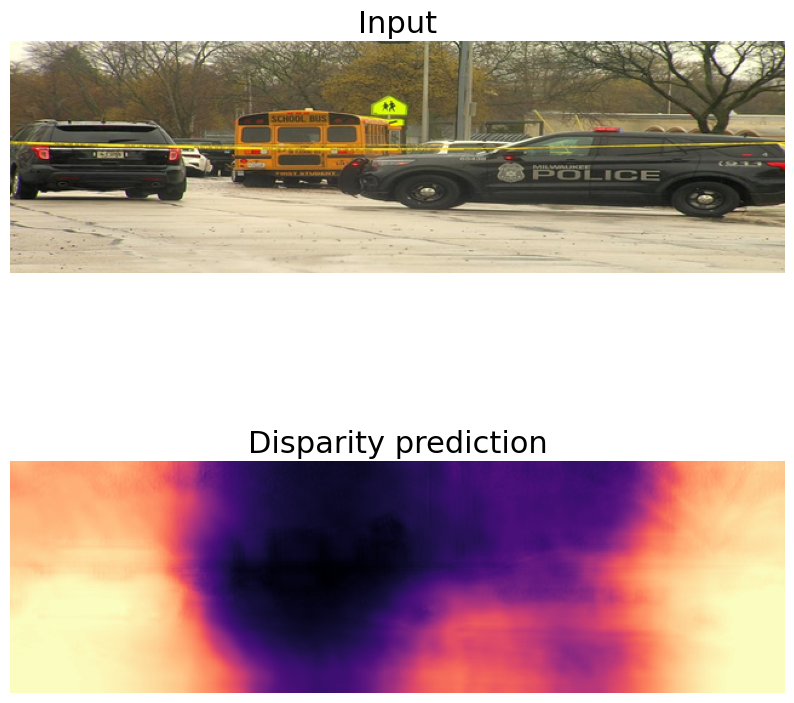

In [ ]:
# Print prediction for model
image_path = "drive/MyDrive/Colab Notebooks/DoAn/Data/test/0000000000.png"
trainer.pred(image_path)